new

In [181]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize, Normalize
from torch.utils.data import DataLoader
from PIL import Image
from scipy.linalg import sqrtm
import numpy as np
import torch.nn.functional as F
from torchvision.models import inception_v3

# Load Pretrained InceptionV3 model
def load_inception_model():
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = torch.nn.Identity()  # Remove the classification layer
    inception.eval()
    return inception

# Compute Inception Score
def compute_inception_score(images, inception, device, splits=10):
    print("Computing Inception Score")
    images = images.to(device)
    with torch.no_grad():
        preds = F.softmax(inception(images), dim=1).cpu().numpy()  # Predict class probabilities
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

# Compute Frechet Inception Distance (FID)
def compute_fid(real_activations, fake_activations):
    print("Calculating FID Score")
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Generate images using the VAE model
def generate_images(vae, num_samples, latent_dim, device):
    print("Generating Images")
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample latent vectors
        generated_images = vae.decoder(z)  # Decode to images
        generated_images = generated_images.clamp(0, 1)  # Ensure values are in the range [0, 1]
        # Convert grayscale to RGB by repeating the channel
        generated_images = generated_images.repeat(1, 3, 1, 1)  # Shape: [batch, 3, H, W]
    return generated_images

# Preprocess images for InceptionV3
def preprocess_images_for_inception(images, resize=299):
    transform = transforms.Compose([
        transforms.Resize((resize, resize)),  # Resize to 299x299 for InceptionV3
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for Inception
    ])
    # Ensure images are float tensors
    images = images.float() if images.dtype == torch.uint8 else images
    images = images / 255.0 if images.max() > 1 else images  # Normalize to [0, 1] if needed
    return torch.stack([transform(image) for image in images])

# Evaluation function using dataset or real images path
def evaluate_vae(vae, dataset, num_generated, latent_dim, device='cpu'):
    print("Evaluating VAE")
    
    # DataLoader for real images
    real_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Load pretrained InceptionV3
    inception = load_inception_model().to(device)

    # Generate images
    generated_images = generate_images(vae, num_generated, latent_dim, device)

    # Resize generated images to 299x299
    generated_images = torch.nn.functional.interpolate(
        generated_images, size=(299, 299), mode="bilinear", align_corners=False
    )

    # Compute real activations
    real_activations = []
    for real_images, _ in real_dataloader:
        real_images = real_images.to(device)
        if real_images.size(1) == 1:  # Check if grayscale
            real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels
        # Resize real images to 299x299
        real_images = torch.nn.functional.interpolate(
            real_images, size=(299, 299), mode="bilinear", align_corners=False
        )
        with torch.no_grad():
            real_activations.append(inception(real_images).cpu().numpy())
    real_activations = np.concatenate(real_activations, axis=0)

    # Compute fake activations
    with torch.no_grad():
        fake_activations = inception(generated_images).cpu().numpy()

    # Compute Inception Score
    inception_score, inception_std = compute_inception_score(generated_images, inception, device)

    # Compute FID
    fid = compute_fid(real_activations, fake_activations)

    print(f"Inception Score: {inception_score} ± {inception_std}")
    print(f"Frechet Inception Distance: {fid}")
    return inception_score, fid

In [182]:
if __name__ == "__main__":
    latent_dim = 32
    batch_size = 32
    epochs = 10
    beta = 2.0
    patience = 7
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and DataLoader
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])
    # dataset = datasets.ImageFolder(root="./photos_classes", transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize VAE and Discriminator
    vae = VAE(latent_dim)
    discriminator = Decoder()

    # # Train VAE with Discriminator
    # vae, discriminator = train_vae(
    #     vae, discriminator, dataloader, epochs, device, beta=beta, patience=patience
    # )

    # Evaluate the VAE
    evaluate_vae(vae, dataset, num_generated=5, latent_dim=latent_dim, device=device)


Evaluating VAE
Generating Images


KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    latent_dim = 32
    batch_size = 32
    epochs = 10
    beta = 2.0
    patience = 7
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and DataLoader
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
    ])
    dataset = datasets.ImageFolder(root="./photos_classes", transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize VAE and Discriminator
    vae = VAE(latent_dim)
    discriminator = Discriminator()

    # # Train VAE with Discriminator
    # vae, discriminator = train_vae(
    #     vae, discriminator, dataloader, epochs, device, beta=beta, patience=patience
    # )

    # Evaluate the VAE
    evaluate_vae(vae, dataset, num_generated=500, latent_dim=latent_dim, device=device)


## Tuning 3

In [312]:
import os
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn.functional as F

In [313]:
# Custom Dataset for Flat Folder Structure
class FlatImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))  # Accept common image formats
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label (all images belong to one class)


# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((28, 28)),                 # Resize to 28x28 for compatibility with FC layers
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

In [314]:
# Encoder with Fully Connected Layers
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
# Decoder with Fully Connected Layers
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat
    

In [315]:
# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [316]:
# Loss Function
def loss_function(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction="sum")  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence
    return recon_loss + kl_divergence

In [317]:
# Hyperparameters
input_dim = 28 * 28  # Flattened input image dimensions (28x28)
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 64
epochs = 10

# Dataset and DataLoader
dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model and Optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Training Loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for images, _ in dataloader:
        images = images.view(-1, input_dim)  # Flatten images
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(images)
        loss = loss_function(images, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(dataloader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

# Save the trained model
torch.save(vae.state_dict(), "models/main_vae_model.pth")

Epoch 1, Loss: 206.4068
Epoch 2, Loss: 186.8069
Epoch 3, Loss: 182.1036
Epoch 4, Loss: 179.6335
Epoch 5, Loss: 177.5189
Epoch 6, Loss: 175.9467
Epoch 7, Loss: 174.9748
Epoch 8, Loss: 174.2002
Epoch 9, Loss: 173.7661
Epoch 10, Loss: 173.2877


In [331]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn

In [332]:
# Load Pretrained InceptionV3 model
def load_inception_model(device):
    inception = models.inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove last FC layer
    inception.to(device)
    inception.eval()
    return inception

In [333]:
# Compute Inception Score
def compute_inception_score(images, inception, device, splits=10):
    images = images.to(device)
    with torch.no_grad():
        preds = torch.softmax(inception(images), dim=1).cpu().numpy()
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

In [334]:
# Compute Frechet Inception Distance (FID)
def compute_fid(real_activations, fake_activations):
    mu1, sigma1 = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [338]:
def evaluate_saved_vae(model_path, dataloader, latent_dim, device, num_samples=5):
    # Initialize the VAE model
    input_dim = 28 * 28  # Assuming the input size is 28x28
    hidden_dim = 400
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)

    # Load the saved state dictionary
    vae.load_state_dict(torch.load(model_path, map_location=device))
    vae.eval()

    generated_images = []
    real_images = []

    for images, _ in dataloader:
        images = images.view(images.size(0), -1).to(device)
        real_images.append(images)
        with torch.no_grad():
            z = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = vae.decoder(z).cpu()
            generated_images.append(fake_images)

    real_images = torch.cat(real_images, dim=0)
    generated_images = torch.cat(generated_images, dim=0)

    # Normalize, reshape, and resize for InceptionV3
    real_images = real_images.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)  # Grayscale to RGB
    real_images = F.interpolate(real_images, size=(75, 75), mode="bilinear")  # Resize to 75x75

    generated_images = generated_images.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
    generated_images = F.interpolate(generated_images, size=(75, 75), mode="bilinear")

    # Load InceptionV3
    inception = load_inception_model(device)

    # Real and Fake activations
    real_activations = []
    fake_activations = []
    with torch.no_grad():
        for imgs in torch.split(real_images, 64):
            real_activations.append(inception(imgs).cpu().numpy())
        for imgs in torch.split(generated_images, 64):
            fake_activations.append(inception(imgs).cpu().numpy())

    real_activations = np.concatenate(real_activations, axis=0)
    fake_activations = np.concatenate(fake_activations, axis=0)

    # Calculate IS and FID
    inception_score, inception_std = compute_inception_score(generated_images, inception, device)
    fid_score = compute_fid(real_activations, fake_activations)

    print(f"Inception Score: {inception_score} ± {inception_std}")
    print(f"FID Score: {fid_score}")

    # Return generated images for visualization
    return generated_images.cpu()

# Display Generated Images
def display_images(images, num_images=16):
    # Assuming images are in shape [batch_size, 1, 28, 28] or [batch_size, 3, H, W]
    images = images[:num_images]  # Select the first `num_images`
    if images.size(1) == 1:  # Grayscale
        images = images.view(-1, 28, 28).cpu().numpy()
    else:  # RGB
        images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to [H, W, C]
    
    plt.figure(figsize=(8, 8))
    for i, img in enumerate(images):
        plt.subplot(4, 4, i + 1)
        if len(img.shape) == 2:  # Grayscale
            plt.imshow(img, cmap="gray")
        else:  # RGB
            plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Dataset Loader for Real Images
class FlatImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))  # Accept common image formats
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label (all images belong to one class)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\1762133260.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path, map_location=devi

Inception Score: 1.0977177619934082 ± 0.003329051425680518
FID Score: 103.6321131421275


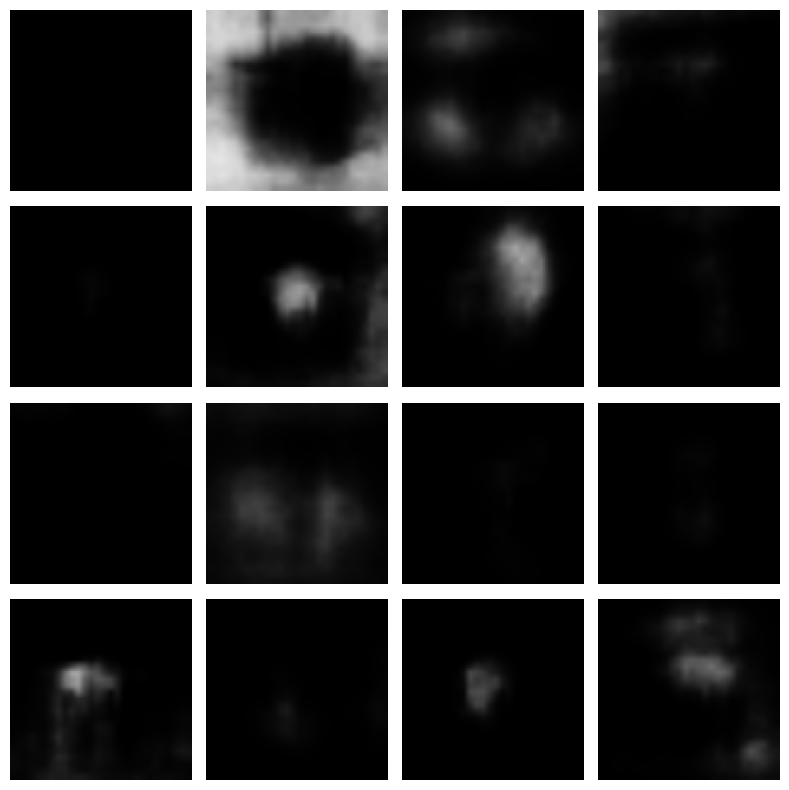

In [339]:
latent_dim = 20
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "models/main_vae_model.pth"  # Path to your saved VAE model

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])
dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Evaluate and Generate Images
generated_images = evaluate_saved_vae(model_path, dataloader, latent_dim, device)

# Display Generated Images
display_images(generated_images)


## Tuning 4

In [342]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import inception_v3
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [343]:
# --- Dataset Definition ---
class FlatImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [
            os.path.join(root, fname) for fname in os.listdir(root)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label

In [344]:
# --- VAE Definition ---
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [345]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

In [346]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [347]:
# --- Loss Function ---
def loss_function(x, x_hat, mu, logvar):
    recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [348]:

# --- Data Preprocessing ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = FlatImageFolder(root="drink", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- Model Training ---
input_dim = 64 * 64  # Flattened input size
hidden_dim = 400
latent_dim = 128
lr = 1e-3
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

vae.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in dataloader:
        x = x.view(-1, input_dim).to(device)  # Flatten the image
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(dataloader.dataset)}")

# Save the trained model
torch.save(vae.state_dict(), "models/main2_vae_model.pth")

Epoch 1, Loss: 1147.1744513301692
Epoch 2, Loss: 1049.2895583220325
Epoch 3, Loss: 1018.8970941189375
Epoch 4, Loss: 998.2435647834237
Epoch 5, Loss: 984.4181833818602
Epoch 6, Loss: 974.32676142709
Epoch 7, Loss: 967.0151503669432
Epoch 8, Loss: 959.94550419791
Epoch 9, Loss: 955.3932870832003
Epoch 10, Loss: 950.7847055480217
Epoch 11, Loss: 947.7086670389278
Epoch 12, Loss: 944.5420469049138
Epoch 13, Loss: 941.4093657765635
Epoch 14, Loss: 939.2906013182036
Epoch 15, Loss: 937.8005942884492
Epoch 16, Loss: 935.4924003868857
Epoch 17, Loss: 934.3980331644863
Epoch 18, Loss: 932.5079351467773
Epoch 19, Loss: 931.3049828992501
Epoch 20, Loss: 930.2436443044033
Epoch 21, Loss: 928.8430993738034
Epoch 22, Loss: 928.2733854000479
Epoch 23, Loss: 927.5800345006381
Epoch 24, Loss: 926.5153640016752
Epoch 25, Loss: 925.718131032626
Epoch 26, Loss: 924.8431669292438
Epoch 27, Loss: 924.6535507737715
Epoch 28, Loss: 923.730501655233
Epoch 29, Loss: 922.9537090678845
Epoch 30, Loss: 922.595491

In [349]:
# --- Evaluation Functions ---
def load_inception_model():
    model = inception_v3(pretrained=True, transform_input=False)
    model.fc = nn.Identity()  # Remove classification head
    model.eval()
    return model

In [350]:
def preprocess_for_inception(images):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to RGB
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return torch.stack([transform(img) for img in images])


In [351]:
def compute_inception_score(images, inception_model):
    images = preprocess_for_inception(images)
    with torch.no_grad():
        preds = F.softmax(inception_model(images), dim=1).cpu().numpy()
    split_scores = []
    for i in range(10):  # Split into 10 batches
        part = preds[i * len(preds) // 10:(i + 1) * len(preds) // 10]
        kl_div = part * (np.log(part) - np.log(np.mean(part, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(split_scores), np.std(split_scores)

In [352]:
def compute_fid(real_features, fake_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)

In [356]:
def evaluate_saved_vae(model_path, dataloader, latent_dim, num_samples=16):
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    # Generate fake images
    z = torch.randn(num_samples, latent_dim).to(device)
    fake_images = vae.decoder(z).view(-1, 1, 64, 64)  # Reshape to image format

    # Real images
    real_images = []
    for x, _ in dataloader:
        real_images.extend(x)
        if len(real_images) >= num_samples:
            break

    # Load Inception model
    inception = load_inception_model().to(device)

    # Compute metrics
    real_features = inception(preprocess_for_inception(real_images).to(device)).cpu().detach().numpy()
    fake_features = inception(preprocess_for_inception(fake_images).to(device)).cpu().detach().numpy()

    is_mean, is_std = compute_inception_score(fake_images, inception)
    fid = compute_fid(real_features, fake_features)

    print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
    print(f"FID Score: {fid:.2f}")
    return fake_images

In [361]:
# --- Display Images ---
def display_images(images, num_images=5):
    images = images[:num_images].detach().cpu().numpy()
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8872\4069874980.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


Inception Score: 1.04 ± 0.00
FID Score: 31356426390489258947804191927958219893703036961285093488599847413493086196522253235332284905802499620864.00


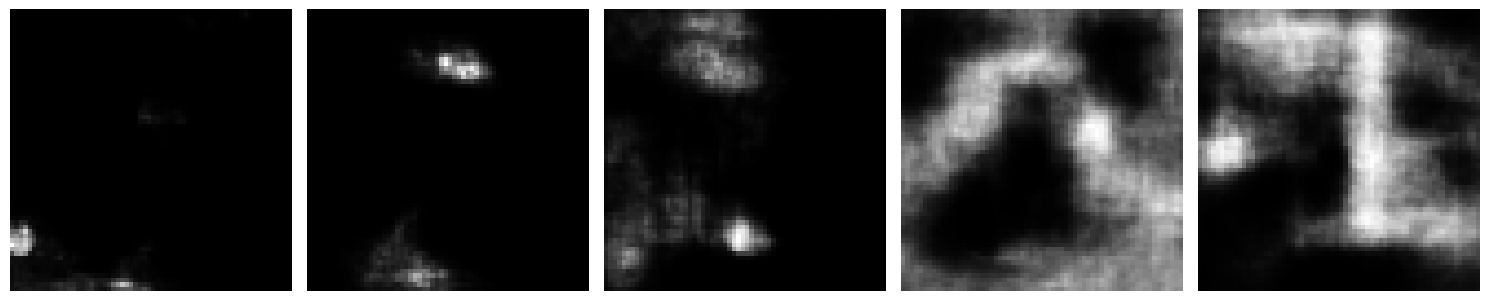

In [362]:
# --- Main Evaluation ---
model_path = "models/main2_vae_model.pth"
generated_images = evaluate_saved_vae(model_path, dataloader, latent_dim, num_samples=64)
display_images(generated_images)